# solving job shop scheduling problem with GA

- [la40 (Tailored Version)](http://jobshop.jjvh.nl/instance.php?instance_id=49#:~:text=as%20text%20file.-,Taillard%20specification,-Specification%20according%20to)


In [1]:
import os
from os import getpid, getppid
from multiprocessing import Pool, cpu_count
from typing import List
import pandas as pd
import numpy as np
import random
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# from plotly.offline import iplot

import plotly.figure_factory as ff
import datetime

from algorithms.genetic_algorithm import initial_population, crossover_by_order
from la40.loader import read_benchmark_task_data
from utils.drawing_tool import create_colors
from utils.paths import JSSP_DATA_PATH
from utils.types import Chromosome

# job数 * machine数 個の int 型要素を持つ遺伝子のためのList型
Chromosome = list[int]

JSSP_DATA_PATH


'/working_dir/notebooks/data/jssp'

# データ読み込み

In [2]:
path: str = os.path.join(JSSP_DATA_PATH, "la40.txt")
processing_time_per_job, machine_sequence_per_job = read_benchmark_task_data(path)

num_machine = len(processing_time_per_job[0])  # number of machines
num_job = len(processing_time_per_job)  # number of jobs
num_gene = num_machine * num_job  # number of genes in a chromosome

# processing_times
pt = processing_time_per_job
#　machine_sequences for tasks
ms = machine_sequence_per_job
# pt

num_job, num_machine

(15, 15)

# GA のモジュール


In [3]:
# def crossover(population_list: list, crossover_rate: float):
#     """
#     2点交叉を行う
#     """
#     parent_list: list = population_list.copy() # preserve the original parent chromosomes
#     offspring_list: list = population_list.copy()

#     # 組み合わせを生成して、交配に使用する親染色体のセットを選択します
#     parent_sequence = list(np.random.permutation(population_size))
#     for i in range(0, population_size, 2):
#         crossover_prob=np.random.rand()
#         if crossover_prob <= crossover_rate:
#             parent_1 = population_list[ parent_sequence[i] ][:]
#             parent_2 = population_list[ parent_sequence[i + 1] ][:]
#             child_1 = parent_1[:]
#             child_2 = parent_2[:]
#             # 2つの異なる交点を生成し、小さいものから大きいものに並べ替えます。
#             crossover_point = list( np.random.choice(num_gene, 2, replace=False) )
#             crossover_point.sort()

#             # parent_2 の中央にある遺伝子が parent_1 の中央に移動され、child1 が生成されます。
#             child_1[crossover_point[0]:crossover_point[1]] = parent_2[crossover_point[0]:crossover_point[1]]
#             # parent_1 の遺伝子を parent_2 に移し、child2 を作る。
#             child_2[crossover_point[0]:crossover_point[1]] = parent_1[crossover_point[0]:crossover_point[1]]

#             offspring_list[parent_sequence[i]] = child_1[:]
#             offspring_list[parent_sequence[i + 1]] = child_2[:]
#     return parent_list, offspring_list


# 染色体内の各アーティファクトの発生数は 10 ですが、上記の交配作用により、一部の染色体におけるアーティファクトの発生数は 10 未満または 10 を超え、
# 実行不可能なスケジューリング ソリューションが形成されるため、ここで次のことを行う必要があります。
# 実行不可能な染色体が修復作用を受けて実行可能なスケジュールになることに焦点を当てる
def repairmet(offspring_list):
    stop = True

    # 各ジョブの発生回数が正しい数になるまで修復を続ける。
    while stop:
        
        for i in range(population_size):
            unique_elements, counts = np.unique( offspring_list[i] , return_counts=True)  # 各ジョブの発生回数
            if sum(counts!= num_machine) != 0:  # 複数の仕事と欠落した仕事 
                less_job = np.argmin(counts)  # 出現回数が不足している job
                large_job = np.argmax(counts)  # 出現回数が超過している job
                offspring_array = np.array( offspring_list[i] )
                offspring_job_large_index = np.where( offspring_array == large_job)[0][0] # より多く出現している job の最初の位置
                offspring_list[i][offspring_job_large_index] = less_job # 出現回数の超過している job_idを、回数の少ない job_id に置換
        counts_sum = 0

        # すべての染色体に異常がないか調べる
        for j in range(population_size):
            unique_elements, counts = np.unique( offspring_list[j] , return_counts=True)
            if sum(counts != num_machine) != 0 :
                counts_sum += 1
        if counts_sum == 0:
            stop = False
    return offspring_list


def mutation(offspring_list, mutation_rate, num_mutation_jobs):
    for i in range(population_size):
        mutation_prob=np.random.rand()
        if  mutation_prob <= mutation_rate:
            # 変異の場所を選ぶ
            mutation_position = list(np.random.choice(num_gene, num_mutation_jobs, replace=False))
            muta_list = []
            for j in mutation_position:
                muta_list.append(offspring_list[i][j]) # 変異させる遺伝子のリスト
            muta_list.append(muta_list[0]) # 先頭の遺伝子を末尾に加える
            muta_list.pop(0) # 先頭の遺伝子を削除
            count = 0
            for k in mutation_position:
                # 変異した遺伝子で、元の遺伝子を置き換える
                offspring_list[i][k] = muta_list[count]
                count += 1
    return offspring_list


def _calc_time4job(
    target_chromosome: Chromosome, num_job: int, num_machine: int
) -> dict[int, int]:
    """
    対象個体の遺伝子をスケジュールにしたときに、実際にどのくらい時間がかかるかを計算する

    len(target_chromosome) => num_job * num_machine
    """
    j_keys: list[int] = [j for j in range(num_job)]
    # job の key 番目のタスクが処理された回数をカウントする
    key_count: dict[int, int] = {key: 0 for key in j_keys}

    # 各 job にかかる時間を格納するための辞書
    time4job: dict[int, int] = {key: 0 for key in j_keys}

    m_keys: list[int] = [j + 1 for j in range(num_machine)]
    time4machine: dict[int, int] = {key: 0 for key in m_keys}

    # 1個体の染色体を一つずつ処理
    for i in target_chromosome:
        # 次に処理すべきタスクのID
        task_no: int = key_count[i]

        # 処理時間
        gen_t: int = int(pt[i][task_no])
        # ジョブにおける、機械の処理順
        gen_m: int = int(ms[i][task_no])

        # i番目のジョブ内のタスク実行にかかった時間合計
        time4job[i] = time4job[i] + gen_t
        # gen_m 番目の機械における処理時間合計
        time4machine[gen_m] = time4machine[gen_m] + gen_t

        # ジョブ毎にかかった時間、もしくは機械毎にかかった時間のうち、小さい方を、大きい方の値で上書きする
        if time4machine[gen_m] < time4job[i]:
            time4machine[gen_m] = time4job[i]
        elif time4machine[gen_m] > time4job[i]:
            time4job[i] = time4machine[gen_m]
        
        key_count[i] = key_count[i] + 1
    return time4job


def fitness_caculate(total_chromosome: list[Chromosome]):
    """
    適応度の計算を行う

    Partameters
    ------
    total_chromosome: list[Chromosome]
        parent and offspring

    Returns
    ------
    chrom_fit: list[int]
        各染色体から計算された makespan の配列 (小さい方が良い)

    chrom_fitness: list[float]
        各染色体から計算された makespan の逆数の配列 (大きい方が良い)

    total_fitness: int
        各染色体から計算された makespan の逆数の合計 (大きい方が良い)
    """
    chrom_fitness, chrom_fit = [], []
    total_fitness: int = 0
    for individual_id in range(population_size * 2):  # 親と子の2世代分ループするので 2倍
        time4job: dict[int, int] = _calc_time4job(total_chromosome[individual_id], num_job, num_machine)

        # 最も時間がかかる仕事は makespan である。
        makespan = max(time4job.values())
        # 各染色体について計算された適応値は、その後ルーレットホイール法を使用する際の完了時間を最小にするために、
        # 逆順に記録されなければならない。
        chrom_fitness.append(1 / makespan)

        # 各染色体の元完了時間の合計を計算する。
        chrom_fit.append(makespan)
        total_fitness = total_fitness + chrom_fitness[individual_id]

    return chrom_fit, chrom_fitness, total_fitness


def selection(chrom_fitness, total_fitness, total_chromosome, population_list):
    """
    selection(roulette wheel approach)
    """
    fitness_prob, fitness_cumulate_prob = [], []

    for i in range(population_size*2):
        # 各染色体のフィットネスを全染色体に占める割合で計算する。
        fitness_prob.append(chrom_fitness[i] / total_fitness)
    for i in range(population_size * 2):
        cumulative = 0
        # 各染色体のフィットネス発生率を計算する。
        for j in range(0, i + 1):
            cumulative = cumulative + fitness_prob[j]
        fitness_cumulate_prob.append(cumulative) 

    # 母集団の大きさを持つ乱数のリストを生成する。
    selection_rand = [np.random.rand() for i in range(population_size)]

    # 新しい population を選択する
    for i in range(population_size):
        # 最初の組合せが選択されたら、最初の染色体を加える
        if selection_rand[i] <= fitness_cumulate_prob[0]:
            population_list[i] = total_chromosome[0].copy()
        else:
            for j in range(0, population_size * 2 - 1): 
                if selection_rand[i] > fitness_cumulate_prob[j] and selection_rand[i] <= fitness_cumulate_prob[j + 1]:
                    population_list[i] = total_chromosome[j + 1].copy()
                    break
    return population_list


def comparsion(chrom_fit, total_chromosome):
    Tbest_current = 99999999999
    for i in range(population_size*2):
        # 最小 fitness の染色体を選択
        if chrom_fit[i] < Tbest_current:
            Tbest_current = chrom_fit[i] 
            sequence_current = total_chromosome[i].copy()
    return Tbest_current, sequence_current

In [4]:
def run_ga(population_list: list[Chromosome]) -> None:
    Tbest: int = 999999999999999
    makespan_record: list[int]= []
    best_gene_history: list[Chromosome] = []
    start_time = time.time()

    population_list = np.array(population_list)
    
    # Genetic_Algorithm 
    for iter in tqdm(range(num_iteration)):
        # generate offspring by crossover
        # parent_list, offspring_list = crossover(population_list=population_list, num_jobs=num_job, crossover_rate=crossover_rate)
        parent_list, offspring_list = crossover_by_order(population_list=population_list, num_jobs=num_job, crossover_rate=crossover_rate)

        # # offspring repairment
        # offspring_list = repairmet(offspring_list)
    
        # offspring mutation
        offspring_list = mutation(offspring_list, mutation_rate = mutation_rate, num_mutation_jobs = num_mutation_jobs)
    
        # all chromosome: parent and offspring
        total_chromosome: np.ndarray = np.concatenate([parent_list.copy(), offspring_list.copy()])
 
        # calculate fitness for each chromosome
        # chrom_fit, chrom_fitness, total_fitness, = fitness_caculate(total_chromosome)
        chrom_fit, chrom_fitness, total_fitness = fitness_caculate(total_chromosome)
    
        # select the new population
        population_list = selection(chrom_fitness, total_fitness, total_chromosome, population_list)
    
        # comparision 
        Tbest_current, sequence_current = comparsion(chrom_fit, total_chromosome)
        # 現在の世代の集団で最も優れた染色体を、反復プロセスで最も優れた染色体と比較します。
        if Tbest_current <= Tbest:
            Tbest = Tbest_current
            sequence_best = sequence_current.copy()
            best_gene_history.append(sequence_best)
    
        makespan_record.append(Tbest)
    
        # 10 分経過したら終了
        lapse_time = time.time() - start_time
        if lapse_time >= timelimit:
            print("Executed iterrations:", iter)
            break
    
    end_time = time.time()
    
    """----------result----------"""
    print("execution_time:", lapse_time)
    print("optimal solution", sequence_best)
    print("optimal makespan:", Tbest)
    
    
    plt.plot([i for i in range(len(makespan_record))], makespan_record, "b")
    plt.ylabel("makespan", fontsize=15)
    plt.xlabel("iteraion", fontsize=15)
    plt.show()

    best_makespans.append(Tbest)
    exec_time_records.append(lapse_time)
    return Tbest, lapse_time, sequence_best


def multi_process(func, args_list: list):
    p = Pool(cpu_count() - 1) # プロセス数を指定する

    try:
        result = p.map(func, args_list)  # リストで引数を指定する
    except Exception as e:
        print("main: ", e)

    p.close()
    return result


def run_ga_wrapper(args):
    print("[p:{}---c:{}] {}\n".format(getppid(), getpid(), [len(args["population_list"])]))
    return run_ga(**args)


In [8]:
# parameter
population_size = 150
# num_iteration = 9999
num_iteration = 9999999
# crossover_rate = 0.95  # 2点交叉用
crossover_rate = 0.5  # 順序に基づく交叉用
mutation_rate = 0.05
mutation_selection_rate = 0.1
num_mutation_jobs = round(num_gene * mutation_selection_rate)
timelimit: float = 36000.0
# timelimit: float = 600.0


## Serial execution

In [ ]:
best_makespans: list[int] = []
exec_time_records: list[int] = []
best_sequences: list[Chromosome] = []
for i in tqdm(range(0, 1)):
    # generate initial population
    population_list: Chromosome = np.array(initial_population(
        num_gene=num_gene, num_job=num_job, population_size=population_size
    ))
    best_score, computation_time, sequence_best = run_ga(population_list)
    best_makespans.append(best_score)
    exec_time_records.append(computation_time)
    best_sequences.append(sequence_best)

best_makespans, exec_time_records, np.mean(best_makespans), np.std(best_makespans)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9999999 [00:00<?, ?it/s]

In [ ]:
best_makespans, exec_time_records, np.mean(best_makespans), np.std(best_makespans)

In [15]:
_best_makespans = [
    1545,
    1565,
    1563,
    1567,
    1554,
    1543,
    1591,
    1566,
    1574,
    1540
]
np.mean(_best_makespans), np.std(_best_makespans)


(1560.8, 14.898322053170954)

## Paralell execution

  0%|          | 0/10 [00:00<?, ?it/s]

[p:21334---c:19932] [150]



  0%|          | 0/9999 [00:00<?, ?it/s]

[p:21334---c:19931] [150]



  0%|          | 0/9999 [00:00<?, ?it/s]

[p:21334---c:19933] [150]



  0%|          | 0/9999 [00:00<?, ?it/s]

[p:21334---c:19934] [150]



  0%|          | 0/9999 [00:00<?, ?it/s]

[p:21334---c:19935] [150]



  0%|          | 0/9999 [00:00<?, ?it/s]

[p:21334---c:19936] [150]



  0%|          | 0/9999 [00:00<?, ?it/s]

[p:21334---c:19937] [150]



  0%|          | 0/9999 [00:00<?, ?it/s]

Executed iterrations: 475
execution_time: 600.9483458995819
optimal solution [64 78 34 ... 70 62 27]
optimal makespan: 7979
Executed iterrations: 478
execution_time: 600.1773014068604
optimal solution [51  2 41 ... 36 31 34]
optimal makespan: 8003


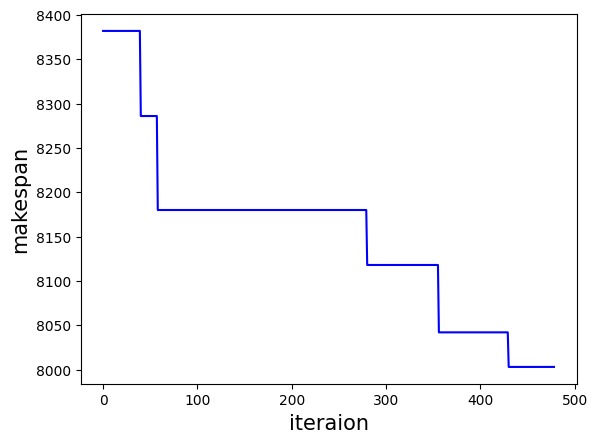

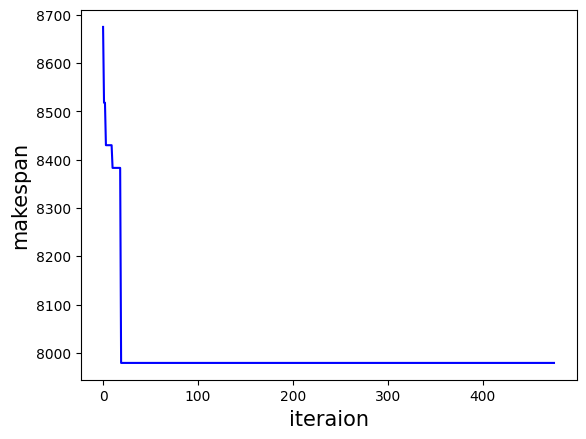

[p:21334---c:19931] [150]



  0%|          | 0/9999 [00:00<?, ?it/s]

Executed iterrations: 475
execution_time: 600.622750043869
optimal solution [34 69 55 ... 71 97  0]
optimal makespan: 7990


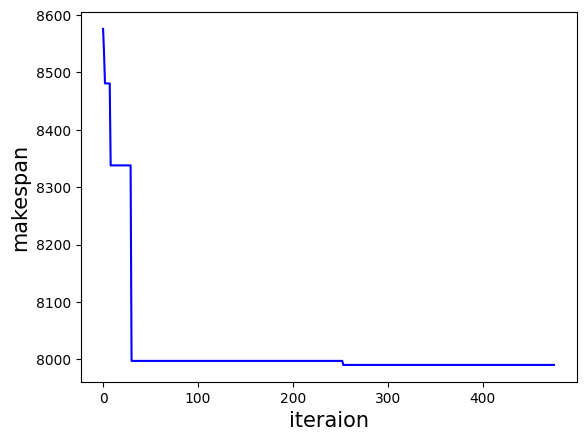

Executed iterrations: 475
execution_time: 600.448872089386
optimal solution [82 81 36 ... 52 92 92]
optimal makespan: 8015
[p:21334---c:19932] [150]



  0%|          | 0/9999 [00:00<?, ?it/s]

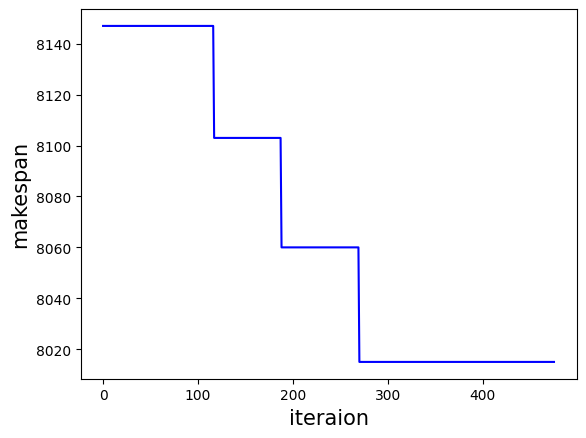

Executed iterrations: 476
execution_time: 600.7834494113922
optimal solution [57 63 77 ... 21 83 36]
optimal makespan: 8046
[p:21334---c:19933] [150]



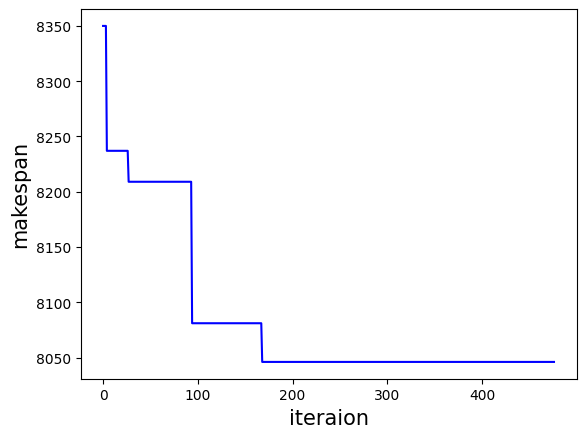

  0%|          | 0/9999 [00:00<?, ?it/s]

Executed iterrations: 477
execution_time: 600.7231357097626
optimal solution [70 48 39 ... 14 85 12]
optimal makespan: 7948


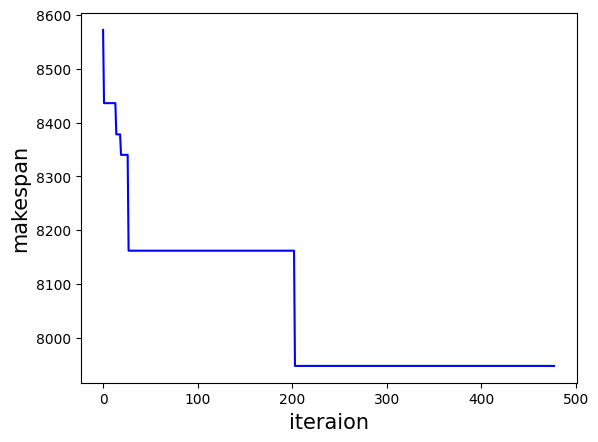

Executed iterrations: 475
execution_time: 601.0066795349121
optimal solution [59 49 98 ... 82 83 42]
optimal makespan: 7898


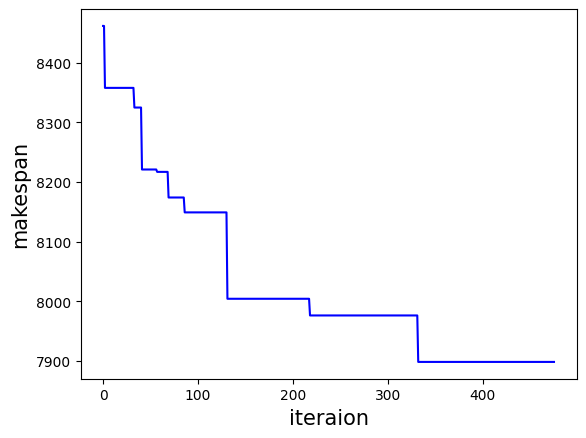

Executed iterrations: 659
execution_time: 600.4003622531891
optimal solution [58 28 87 ... 92 24 33]
optimal makespan: 7995


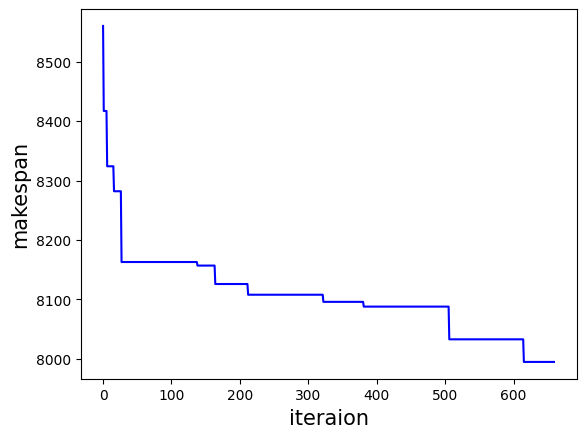

Executed iterrations: 656
execution_time: 600.0427372455597
optimal solution [76 22 32 ... 78 75 39]
optimal makespan: 7914


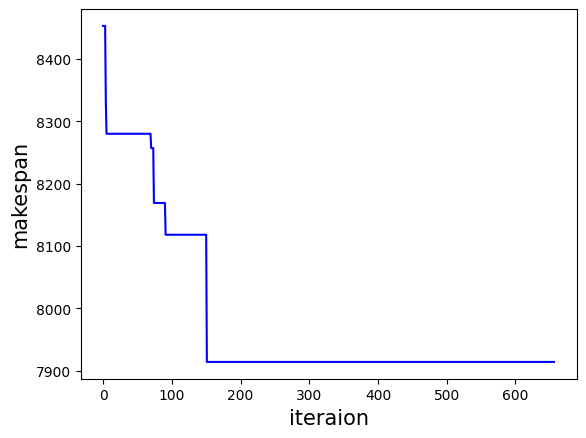

Executed iterrations: 657
execution_time: 600.5754525661469
optimal solution [99 70  9 ... 66 99 44]
optimal makespan: 8069


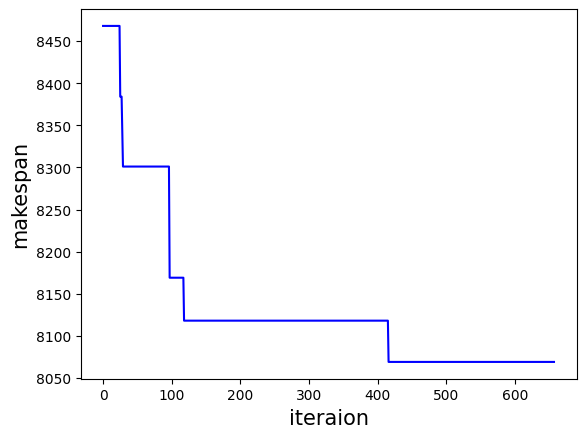

In [29]:
# generate initial population for 10 iterations
population_lists: list[dict[str, list[Chromosome]]] = [
    {"population_list": initial_population(
        num_gene=num_gene, num_job=num_job, population_size=population_size
    )}
    for _ in tqdm(range(0, 10))
]

result: list[tuple] = multi_process(run_ga_wrapper, population_lists)


In [30]:
# # la40
# exec_iterations = [3690, 3688, 3697, 3688, 3689, 3696, 3686, 4956, 4979, 4975]
# np.mean(exec_iterations), np.std(exec_iterations)

# ta40
exec_iterations = [475, 478, 475, 475, 476, 477, 475, 659, 656, 657]
np.mean(exec_iterations), np.std(exec_iterations)

(530.3, 83.17096849261766)

In [31]:
best_makespans: list[int] = []
exec_time_records: list[int] = []
best_sequences: list[Chromosome] = []
for best_score, computation_time, sequence_best in result:
    best_makespans.append(best_score)
    exec_time_records.append(computation_time)
    best_sequences.append(sequence_best)

np.mean(best_makespans), np.std(best_makespans)


(7985.7, 51.123477972454104)

In [20]:
best_makespans[-4]


1558

# Visualization

In [ ]:
def prepare_gannt_data_from(
    m_keys: list[int], j_keys: list[int], sequence_best: list[int]
) -> dict:
    key_count = {key: 0 for key in j_keys}
    j_count = {key: 0 for key in j_keys}
    m_count = {key: 0 for key in m_keys}
    j_record = {}
    
    for job_id in sequence_best:
        gen_t: int = int(pt[job_id][key_count[job_id]])
        machine_id: int = int(ms[job_id][key_count[job_id]])
        j_count[job_id] = j_count[job_id] + gen_t
        m_count[machine_id] = m_count[machine_id] + gen_t
        
        if m_count[machine_id] < j_count[job_id]:
            m_count[machine_id] = j_count[job_id]
        elif m_count[machine_id] > j_count[job_id]:
            j_count[job_id] = m_count[machine_id]
    
        # convert seconds to hours, minutes and seconds
        start_time: str = str(datetime.timedelta(seconds=j_count[job_id] - pt[job_id][key_count[job_id]]))
        end_time: str = str(datetime.timedelta(seconds=j_count[job_id]))
            
        j_record[(job_id, machine_id)] = [start_time, end_time]
        
        key_count[job_id] = key_count[job_id] + 1

    return j_record


def format_gannt_data(m_keys: list[int], j_keys: list[int], j_record):
    frame_dicts = []
    for m in m_keys:
        for j in j_keys:
            frame_dicts.append(dict(
                Task="Machine %s"%(m),
                Start="2023-10-15 %s"%(str(j_record[(j, m)][0])),
                Finish="2023-10-15 %s"%(str(j_record[(j, m)][1])),
                Resource="Job %s"%(j+1))
            )
            # df.append(dict(Task="Machine %s"%(m), Start="2018-07-14 %s"%(str(j_record[(j,m)][0])), Finish="2018-07-14 %s"%(str(j_record[(j,m)][1])),Resource="Job %s"%(j+1)))
    return frame_dicts

sequence_best = best_sequences[-4]

m_keys = [j + 1 for j in range(num_machine)]
j_keys = [j for j in range(num_job)]
j_record: dict = prepare_gannt_data_from(m_keys, j_keys, sequence_best)

frame_dicts: list[dict] = format_gannt_data(m_keys, j_keys, j_record)

colors: List[str] = create_colors(num_job)
fig = ff.create_gantt(
    frame_dicts, index_col="Resource", colors=colors,
    show_colorbar=True, group_tasks=True, showgrid_x=True, title="Job shop Schedule"
)
# iplot(fig, filename="GA_job_shop_scheduling")
fig

# Animation

In [54]:
import io
import numpy as np
import plotly
from PIL import Image
from parapara import play_anim


def plotly_fig2array(fig: plotly.graph_objs.Figure, width: int, height: int):
    # convert Plotly fig to an array
    if (width is not None) and (height is not None):
        fig_bytes = fig.to_image(format="png", width=width, height=height)
    else:
        fig_bytes = fig.to_image(format="png")
    buf = io.BytesIO(fig_bytes)
    img = Image.open(buf)
    return np.asarray(img)


numpy_frames = []
best_gene_history.append(sequence_best)
for gene in tqdm(best_gene_history):
    j_record_: dict = prepare_gannt_data_from(m_keys, j_keys, gene)
    frame_dicts_: list[dict] = format_gannt_data(m_keys, j_keys, j_record_)
    fig_ = ff.create_gantt(
        frame_dicts_, index_col="Resource", colors=colors,
        show_colorbar=True, group_tasks=True, showgrid_x=True, title="Job shop Schedule"
    )
    numpy_array = plotly_fig2array(fig_, 1000, 500)
    numpy_frames.append(numpy_array)



  0%|          | 0/19 [00:00<?, ?it/s]

In [ ]:
play_anim(numpy_frames)
